# Lab 2_кластерный анализ в задаче сегментации пользователей

Описание задачи:
Для понимания структуры платящих пользователей очень часто используются алгоритмы кластеризации, изначально мы не знаем какие классы удастся выделить и сколько их будет. В общем случае нам интересно выделить пользователей, которые приносят в наш продукт большую часть денег, пользователей которые представляют некий портрет среднего пользователя нашего продукта и пользователей, которые по каким-то причинам не очень охотно платят. 

В качестве “подопытного кролика” предлагается рассмотреть набор данных Segmetation.csv со следующей структурой:

* CustomerId - уникальный идентификатор пользователя
* Monetary - объем средств, который пользователь принес в продукт за анализируемый период времени
* Recency -  время последнего платежа пользователя за анализируемый период времени
* Frequency - количество платежей, которое пользователь совершил за анализируемый период времени
* factor_* - замаскированные показатели

Есть описательные статистики разных  пользователей. Найдите среди всех пользователей похожие группы, проведите кластерный анализ и подумайте есть ли здесь вообще зависимости или нет? 


Задачи:

* 1 - Необходимо разработать модель, которая позволит разделить пользователей на классы по их платежному поведению, должна получится ясная картина того, в какой класс попал каждый пользовать и почему, количество классов определяете Вы, руководствуясь аналитикой и здравым смыслом. Возможна ситуация, когда ряд пользователь не попал ни в один из выделенных классов, таких пользователей можно отнести к классу Other, но он не должен быть слишком большим, не забывайте, что цель разработки данной модели -  понять структуру платящих пользователей продукта, а не запутаться еще больше. В качестве основы модели могут использоваться алгоритмы машинного обучения или методы классической аналитики.
* 2 - показать средние значения факторов в разных кластерах
* 3 - ответить на вопрос, какие из факторов не несут информации. Ответом на Задание 3 являются названия факторов без какой-либо информации через запятую
* 4 - в коде напишите, какие кластеры Вы выделили и почему
* 5 - визуализируйте кластеры

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#Загрузим нужные модули: для кластеризации и доступа к датасетам
from sklearn import cluster, datasets
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
data = pd.read_csv('KA_segm.csv', encoding='cp1251', low_memory=False)
data.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


Удалим столбец ```CustomerId```, так как для каждого пользователя это значение уникально

In [ ]:
data.drop(['CustomerId',], axis=1, inplace=True)

In [ ]:
data.head()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


Так как признак ```Recency``` - время последнего платежа пользователя за анализируемый период времени, и каждое значение содержит 2019 год, то преобразуем его в количество дней, прошедших с 2018 года.

In [ ]:
data.Recency.unique()

array(['2019-06-04', '2019-05-25', '2019-03-20', '2019-04-10',
       '2019-03-01', '2019-06-08', '2019-02-18', '2019-05-13',
       '2019-03-15', '2019-01-02', '2019-01-27', '2019-03-22',
       '2019-06-07', '2019-05-23', '2019-03-16', '2019-05-08',
       '2019-06-14', '2019-03-24', '2019-06-13', '2019-06-03',
       '2019-06-09', '2019-02-04', '2019-03-28', '2019-04-14',
       '2019-04-24', '2019-06-02', '2019-02-10', '2019-03-26',
       '2019-05-10', '2019-04-25', '2019-01-04', '2019-06-16',
       '2019-05-05', '2019-04-11', '2019-03-30', '2019-03-12',
       '2019-04-21', '2019-05-04', '2019-01-29', '2019-06-10',
       '2019-04-28', '2019-04-13', '2019-03-18', '2019-01-26',
       '2019-04-19', '2019-03-09', '2019-01-01', '2019-04-22',
       '2019-05-22', '2019-05-03', '2019-01-25', '2019-03-13',
       '2019-04-12', '2019-01-17', '2019-06-12', '2019-05-11',
       '2019-01-21', '2019-02-14', '2019-03-29', '2019-05-24',
       '2019-01-05', '2019-05-26', '2019-01-09', '2019-

In [ ]:
from datetime import datetime
data['Recency'] = data['Recency'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month*30 + datetime.strptime(x, '%Y-%m-%d').day)

In [ ]:
data['Recency'] = data['Recency'] - data['Recency'].min()

In [ ]:
data.head()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,153,6,0.35,0.08,0.609740,0.949383
1,170.00,144,4,0.66,0.16,0.942272,0.479846
2,70.75,144,6,0.92,0.20,0.323030,0.007076
3,75.00,79,10,0.35,0.78,0.876833,0.088974
4,94.51,99,5,0.51,0.44,0.912099,0.206194


In [ ]:
from sklearn.cluster import KMeans

k_means = cluster.KMeans(n_clusters = 4)
k_means.fit(data) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
data['K-Means_clust'] = k_means.fit_predict(data)

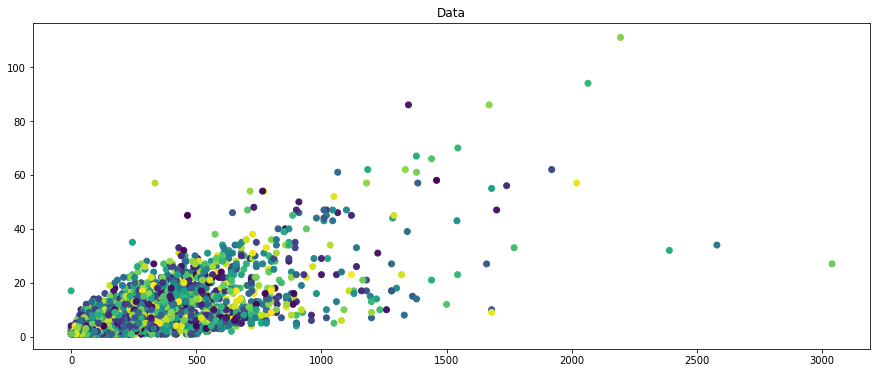

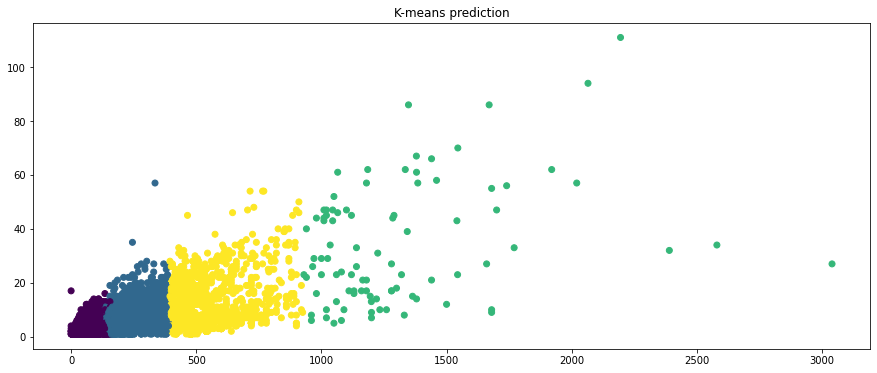

In [ ]:
plt.scatter(data['Monetary'], data['Frequency'], c = data['factor_1'])
plt.title('Data')
plt.show()

plt.scatter(data['Monetary'], data['Frequency'], c = k_means.labels_)
plt.title('K-means prediction')
plt.show()

In [ ]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=4)
brc.fit(data)
brc_clusters = brc.predict(data)

In [ ]:
data['Birch_predict'] = brc_clusters

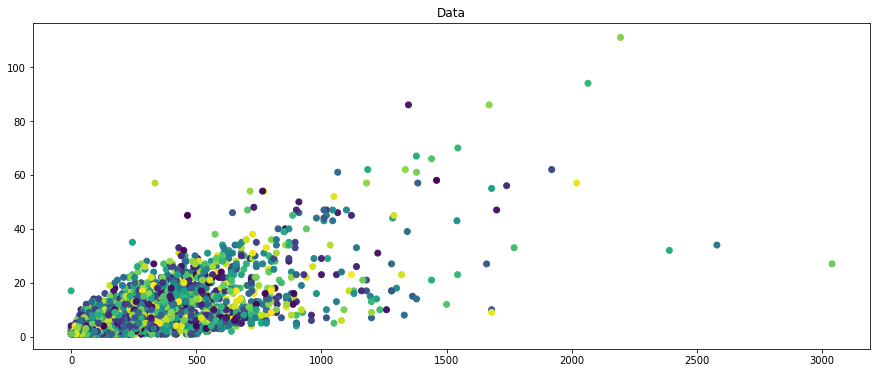

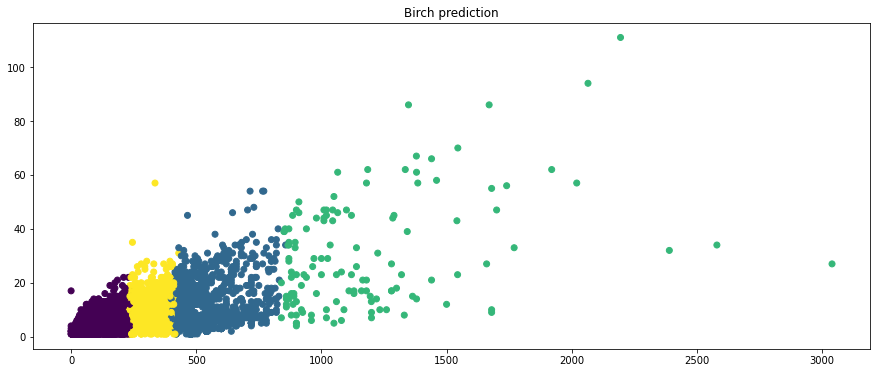

In [ ]:
plt.scatter(data['Monetary'], data['Frequency'], c = data['factor_1'])
plt.title('Data')
plt.show()

plt.scatter(data['Monetary'], data['Frequency'], c = brc.labels_)
plt.title('Birch prediction')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4,affinity="l1",linkage="complete")

In [ ]:
data['Aggl_predict'] = clustering.fit_predict(data)

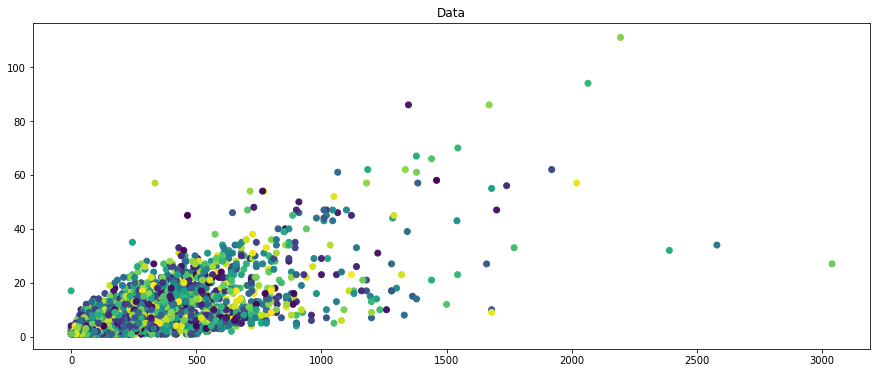

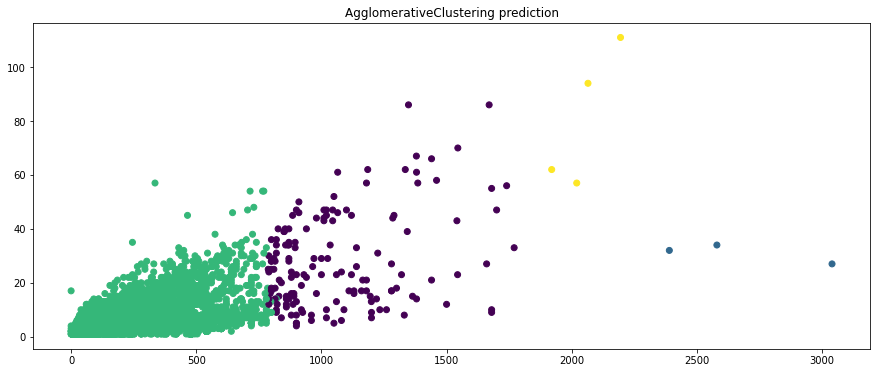

In [ ]:
plt.scatter(data['Monetary'], data['Frequency'], c = data['factor_1'])
plt.title('Data')
plt.show()

plt.scatter(data['Monetary'], data['Frequency'], c = clustering.labels_)
plt.title('AgglomerativeClustering prediction')
plt.show()

In [ ]:
data.head()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,K-Means_clust,Birch_predict,Aggl_predict
0,100.40,153,6,0.35,0.08,0.609740,0.949383,0,0,2
1,170.00,144,4,0.66,0.16,0.942272,0.479846,1,0,2
2,70.75,144,6,0.92,0.20,0.323030,0.007076,0,0,2
3,75.00,79,10,0.35,0.78,0.876833,0.088974,0,0,2
4,94.51,99,5,0.51,0.44,0.912099,0.206194,0,0,2


In [ ]:
data.groupby('K-Means_clust').mean()[['Monetary',	'Recency',	'Frequency']]

,Monetary,Recency,Frequency
K-Means_clust,,,
0,45.368590,98.172122,2.291088
1,241.769963,128.143033,6.444513
2,1305.478681,146.021978,33.659341
3,543.599313,130.287252,10.755795


In [ ]:
data.groupby('K-Means_clust').count()['factor_1']

K-Means_clust
0    11457
1     3244
2       91
3     1208
Name: factor_1, dtype: int64

In [ ]:
data.groupby('Birch_predict').mean()[['Monetary',	'Recency',	'Frequency']]

,Monetary,Recency,Frequency
Birch_predict,,,
0,62.792560,102.131982,2.710280
1,542.395349,129.479779,10.268382
2,1180.682868,146.736434,30.534884
3,309.093506,127.137349,7.550000


In [ ]:
data.groupby('Birch_predict').count()['factor_1']

Birch_predict
0    13123
1     1088
2      129
3     1660
Name: factor_1, dtype: int64

In [ ]:
data.groupby('Aggl_predict').mean()[['Monetary',	'Recency',	'Frequency']]

,Monetary,Recency,Frequency
Aggl_predict,,,
0,1060.230872,147.275168,27.859060
1,2670.000000,161.666667,31.000000
2,120.258257,106.542792,3.701275
3,2050.000000,159.000000,81.000000


In [ ]:
data.groupby('Aggl_predict').count()['factor_1']

Aggl_predict
0      149
1        3
2    15844
3        4
Name: factor_1, dtype: int64

Исходя из всех моделей, можно выделить 3-4 кластера:

**0 кластер** - люди, которые внесли всего денег небольшое кол-во, и нечасто, и позже относительно других групп: их большинство

**1 кластер** - люди, которые всего внесли среднее кол-во денег, чаще чем 0 группа

**2 кластер** - люди, которые всего внесли много, часто, и недавно

**0 кластер** - люди, которые всего внесли больше всех денег, чащеИ 